In [1]:
import math
import numpy as np
import pandas as pd
import quaternion
from skinematics import quat, rotmat, vector
from skinematics.sensors.manual import MyOwnSensor
import sqlite3

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


Implementation of the complementary filter which is not implemented in skinematics.
See the matura thesis for more information and the file `filter_implementations.py` 
for a complete implementation.

In [2]:
def complementary_filter(acc, omega, mag, rate, init, hp=0.98):
    roll = []
    pitch = []
    yaw = []
    
    lp = 1 - hp
    
    theta_1 = init[0] * (math.pi/180)
    phi_1 = init[1] * (math.pi/180)
    psi_1 = init[2] * (math.pi/180)
    
    for i, n in enumerate(acc):
        accv = acc[i]
        omegav = omega[i]
        magv = mag[i]
        
        accv = vector.normalize(accv)
        omegav = vector.normalize(omegav)
        magv = vector.normalize(magv)

        theta = math.atan(accv[1]/accv[2])
        phi = math.atan(-accv[0]/math.sqrt(accv[1] * accv[1]+accv[2] * accv[2]))
        
        psi = math.atan(magv[0] * math.cos(phi) + magv[2] * math.sin(phi)/magv[0] * math.sin(theta) + magv[1] * math.cos(phi) - magv[2] * math.sin(theta) * math.cos(phi))
        
        theta_1 = (theta_1 + omegav[0] * 1.0/rate) * hp + theta * lp
        phi_1 = (phi_1 + omegav[1] * 1.0/rate) * hp + phi * lp
        psi_1 = (psi_1 + omegav[2] * 1.0/rate) * hp + psi * lp
        
        roll.append(theta_1)
        pitch.append(phi_1)
        yaw.append(psi_1)
        
    return (roll, pitch, yaw)
        

Import of data from a previous recording. The Location of the recording and the table are specified in the variables
`path_to_db` and `tablename`

In [23]:
path_to_db = ''
tablename = ''
id = 0

con = sqlite3.connect(path_to_db)
cur = con.cursor()
cur.execute('SELECT * FROM ' + tablename)
results = cur.fetchall()


cur.execute('SELECT * FROM recording_euler')
reference = cur.fetchall()

reference[0]

cur.execute('SELECT * FROM recording_init')
init = cur.fetchall()
init

[(0, 343.375, 46.5625, 12.5)]

In [50]:
# organize data
data = {}
ids = []
# reference_values = []
# 0 -> id
# 1-3 -> acc
# 4-6 -> gyro
# 7-9 -> mag
# 10-12 -> euler
# 13 -> gen

for row in results:
    if row[0] in ids:
        data[row[0]]['acc'].append(row[1:4])
        data[row[0]]['gyr'].append(row[4:7])
        data[row[0]]['mag'].append(row[7:10])
    else:
        ids.append(row[0])
        data[row[0]] = {'acc': [], 'gyr': [], 'mag': []}
        data[row[0]]['acc'].append(row[1:4])
        data[row[0]]['gyr'].append(row[4:7])
        data[row[0]]['mag'].append(row[7:10])
                        

in_data = {'rate': 1/10,
          'acc': np.array(data[0]['acc']),
          'omega': np.array(data[0]['gyr']),
          'mag': np.array(data[0]['mag'])}

in_data_mad = {'rate': 10 ,  # there seems to be an error in the library
          'acc': np.array(data[0]['acc']),
          'omega': np.array(data[0]['gyr']),
          'mag': np.array(data[0]['mag'])}

# convert the initial position to a rotation matrix 
Rx = rotmat.R('x', 0)
Ry = rotmat.R('y', 0)
Rz = rotmat.R('z', 0)

R_init = np.dot(Rz, np.dot(Ry, Rx))

In [51]:
# run filters for one sensor


sensor = MyOwnSensor(in_data=in_data_mad, R_init=R_init, q_type='madgwick')

# analytical ('raw') orientation
q_mad = sensor.quat

# kalman
sensor = MyOwnSensor(in_data=in_data, R_init=R_init, q_type='kalman')
q_kalman = sensor.quat

# madgwick
sensor = MyOwnSensor(in_data=in_data, R_init=R_init, q_type='analytical')
q_analytic = sensor.quat

# complementary
roll_com, pitch_com, yaw_com = complementary_filter(data[0]['acc'], data[0]['gyr'], data[0]['mag'], 10, (0, 0, 0), 0.98)


Calculating the Quaternions [#########################] 480/480


C:\Users\coret\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


In [52]:
# convert quaternions into euler angles
angles_analytic = []
angles_kal = []
angles_mad = []
for q in q_analytic:
    degs = quat.quat2deg(q)
    angles_analytic.append(degs)
for q in q_kalman:
    degs = quat.quat2deg(q)
    angles_kal.append(degs)
for q in q_mad:
    degs = quat.quat2deg(q)
    angles_mad.append(degs)
for i, n in enumerate(roll_com):
    roll_com[i] = roll_com[i] * (180/math.pi)
    pitch_com[i] = pitch_com[i] * (180/math.pi)
    yaw_com[i] = yaw_com[i] * (180/math.pi)

In [53]:
# plot data
from matplotlib import pyplot as plt
import os

roll_reference = []
roll_analytical = []
roll_kal = []
roll_mad = []

pitch_reference = []
pitch_analytical = []
pitch_kal = []
pitch_mad = []

yaw_reference = []
yaw_analytical = []
yaw_kal = []
yaw_mad = []

roll = []
pitch = []
yaw = []

print(reference[0])

for i, a in enumerate(angles_analytic):  # TODO: Add complementary
    if i > 474:
            roll_reference.append(reference[i][1])
    else:
        roll_reference.append(reference[i][1])
    roll_analytical.append(a[0])
    roll_kal.append(angles_kal[i][0])
    roll_mad.append(angles_mad[i][0])
    roll.append([reference[i][1], a[0], angles_kal[i][0], angles_mad[i][0]])
    
    pitch_reference.append(reference[i][2])
    pitch_analytical.append(a[1])
    pitch_kal.append(angles_kal[i][1])
    pitch_mad.append(angles_mad[i][1])
    pitch.append([reference[i][2], a[1], angles_kal[i][1], angles_mad[i][1]])
    
    yaw_reference.append(reference[i][3])
    yaw_analytical.append(a[2])
    yaw_kal.append(angles_kal[i][2])
    yaw_mad.append(angles_mad[i][2])
    yaw.append([reference[i][3], a[2], angles_kal[i][2], angles_mad[i][2]])
    
    
# calculate per point deviations
delta_roll_analytical = (np.array(roll_analytical)) - (np.array(roll_reference))
delta_pitch_analytical = (np.array(pitch_analytical)) - (np.array(pitch_reference))
delta_yaw_analytical = (np.array(yaw_analytical)) - (np.array(yaw_reference))

delta_roll_com = (np.array(roll_com) - np.array(roll_reference))
delta_pitch_com = (np.array(pitch_com) - np.array(pitch_reference))
delta_yaw_com = (np.array(yaw_com) - np.array(yaw_reference))

delta_roll_kal = (np.array(roll_kal) - np.array(roll_reference))
delta_pitch_kal = (np.array(pitch_kal) - np.array(pitch_reference))
delta_yaw_kal = (np.array(yaw_kal) - np.array(yaw_reference))

delta_roll_mad = (np.array(roll_mad) - np.array(roll_reference))
delta_pitch_mad = (np.array(pitch_mad) - np.array(pitch_reference))
delta_yaw_mad = (np.array(yaw_mad) - np.array(yaw_reference))

# calculate means

means = [np.mean(delta_roll_analytical), np.mean(delta_pitch_analytical), np.mean(delta_yaw_analytical),
                 np.mean(delta_roll_com), np.mean(delta_pitch_com), np.mean(delta_yaw_com),
                 np.mean(delta_roll_kal), np.mean(delta_pitch_kal), np.mean(delta_yaw_kal),
                 np.mean(delta_roll_mad), np.mean(delta_pitch_mad), np.mean(delta_yaw_mad)]

(0, 28.25, 11.25, -99.625, 0)


C:\Users\coret\Documents\Maturarbeit\Notebooks\imu-mocap


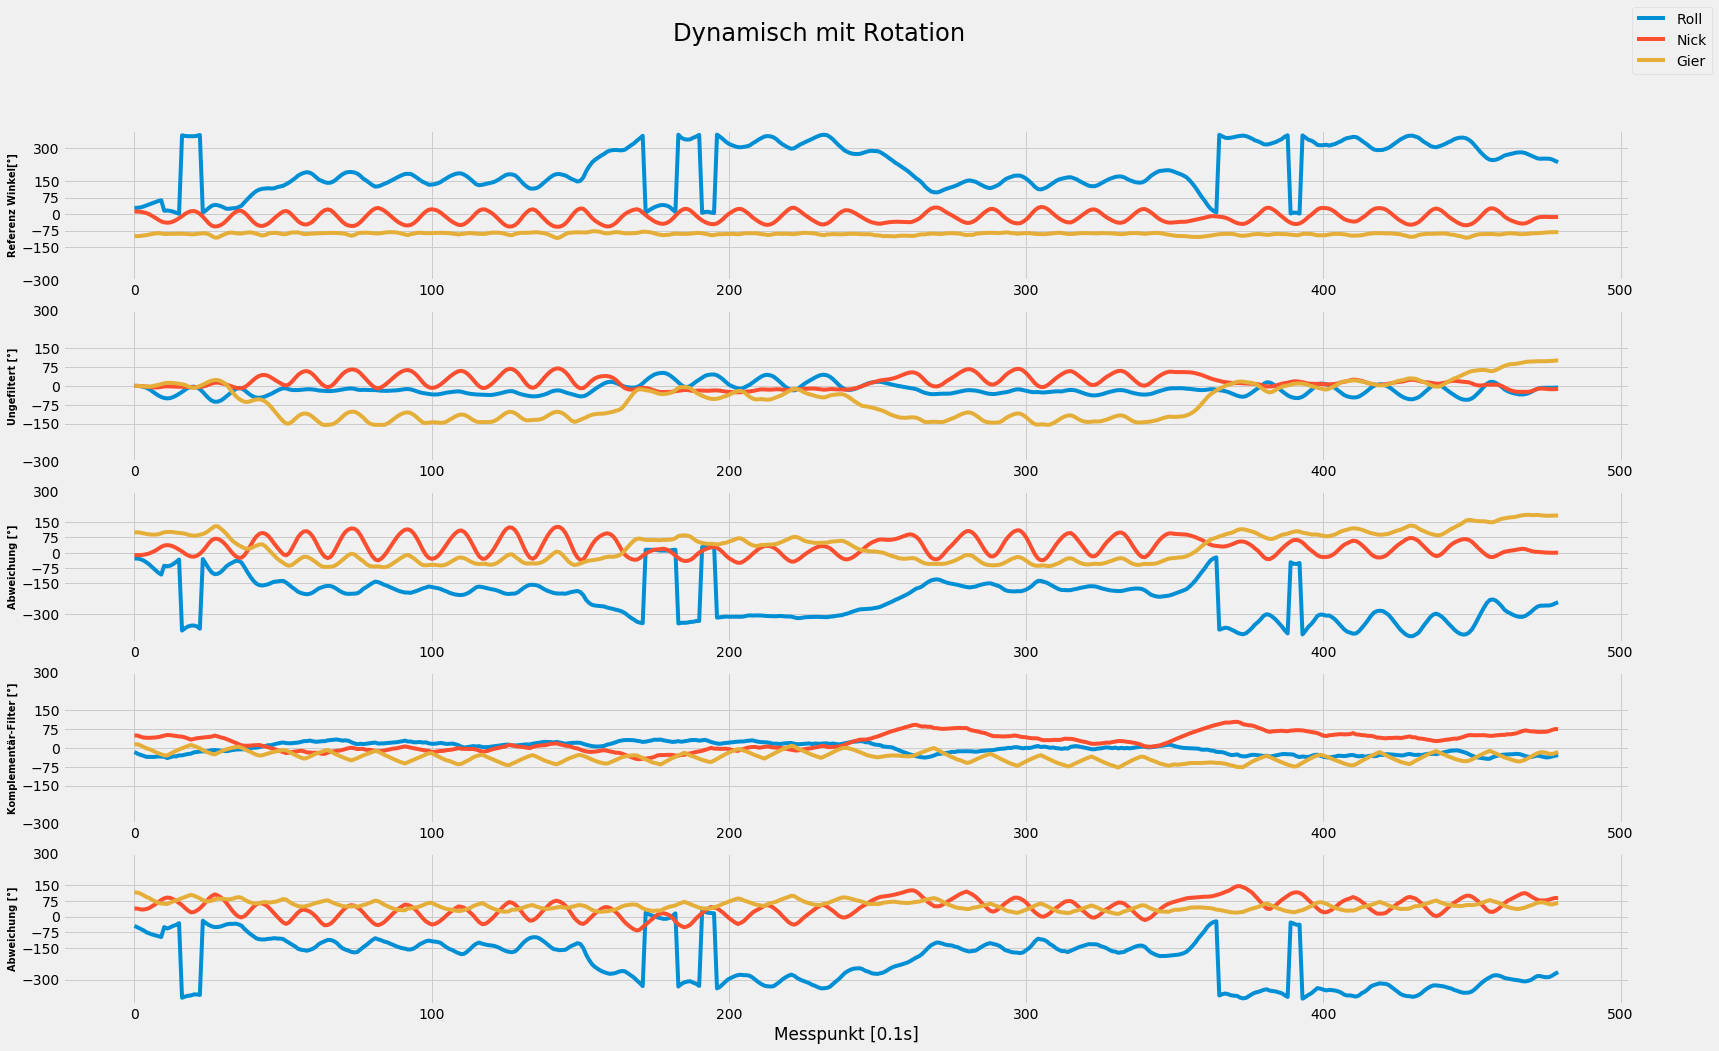

In [54]:
plt.style.use('fivethirtyeight')

# generate axes
x = list(range(len(q_analytic)))
xticks = np.array(list(range(0, 40))) * 40
yticks = np.array(list(range(-9, 10))) * 10

fig = plt.figure(figsize=(25,15))
p1 = fig.add_subplot(511)  # reference
p2 = fig.add_subplot(512)  # analytical
p3 = fig.add_subplot(513)  # delta
p4 = fig.add_subplot(514)  # complementary
p5 = fig.add_subplot(515)  # delta

fig.suptitle('Dynamisch mit Rotation', fontsize='xx-large')

p1.plot(x, roll_reference)
p1.plot(x, pitch_reference)
p1.plot(x, yaw_reference)
p1.set_ylabel('Referenz Winkel[°]', fontsize='x-small', fontweight='bold')

p2.plot(x, roll_analytical)
p2.plot(x, pitch_analytical)
p2.plot(x, yaw_analytical)
p2.set_ylabel('Ungefiltert [°]', fontsize='x-small', fontweight='bold')

p3.plot(x, delta_roll_analytical)
p3.plot(x, delta_pitch_analytical)
p3.plot(x, delta_yaw_analytical)
p3.set_ylabel('Abweichung [°]', fontsize='x-small', fontweight='bold')

p4.plot(x, roll_com)
p4.plot(x, pitch_com)
p4.plot(x, yaw_com)
p4.set_ylabel('Komplementär-Filter [°]', fontsize='x-small', fontweight='bold')

p5.plot(x, delta_roll_com)
p5.plot(x, delta_pitch_com)
p5.plot(x, delta_yaw_com)
p5.set_ylabel('Abweichung [°]', fontsize='x-small', fontweight='bold')
p5.set_xlabel('Messpunkt [0.1s]')

yticks = [-200, -100, 0, 100, 200]
p1.set_yticks([-300, -150, -75, 0, 75, 150, 300])
p2.set_yticks([-300, -150, -75, 0, 75, 150, 300])
p3.set_yticks([-300, -150, -75, 0, 75, 150, 300])
p4.set_yticks([-300, -150, -75, 0, 75, 150, 300])
p5.set_yticks([-300, -150, -75, 0, 75, 150, 300])

l1, l2, l3 = p1.lines

fig.legend((l1, l2, l3), ('Roll', 'Nick', 'Gier'), 'upper right')

fig.savefig(os.path.join(os.getcwd(), 'test.png'))
print(os.getcwd())

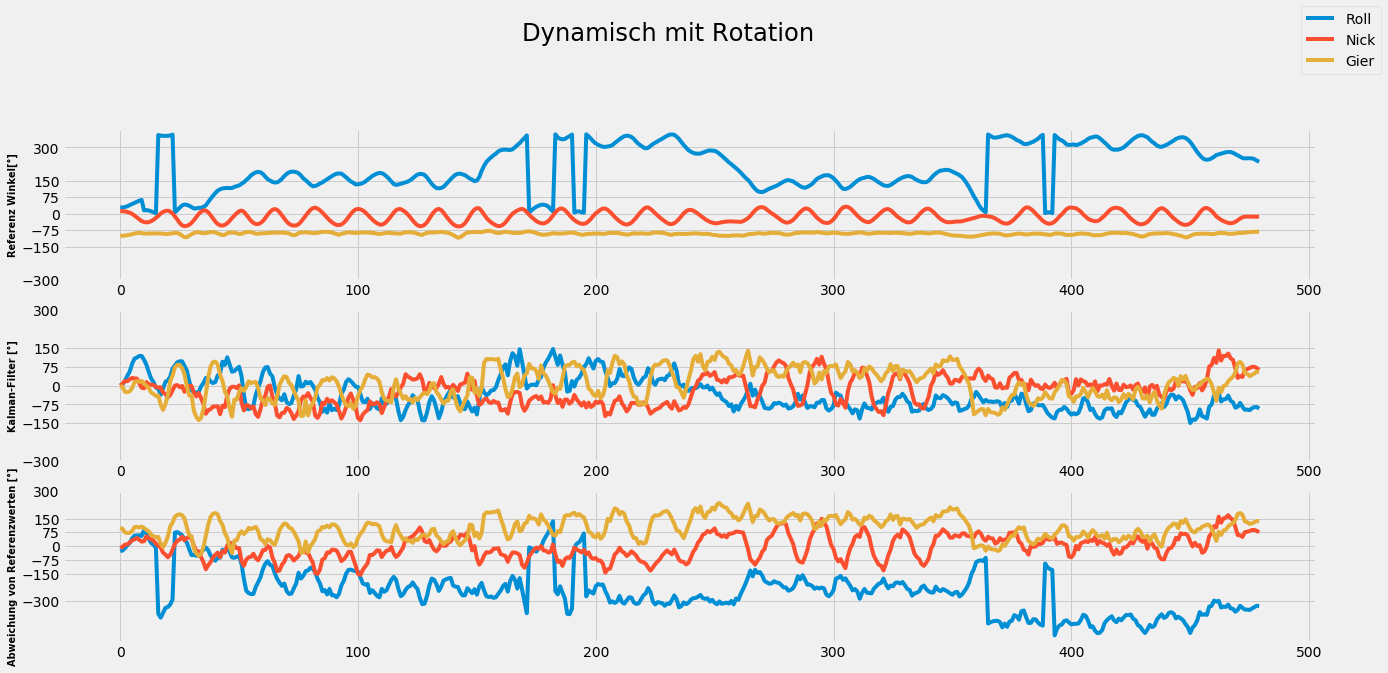

In [55]:
plt.style.use('fivethirtyeight')

# generate axes
x = list(range(len(q_analytic)))
xticks = np.array(list(range(0, 40))) * 40
yticks = np.array(list(range(-9, 10))) * 10

fig = plt.figure(figsize=(20,15))
p1 = fig.add_subplot(511)  # reference
p2 = fig.add_subplot(512)  # kalman
p3 = fig.add_subplot(513)  # delta

fig.suptitle('Dynamisch mit Rotation', fontsize='xx-large')

p1.plot(x, roll_reference)
p1.plot(x, pitch_reference)
p1.plot(x, yaw_reference)
p1.set_ylabel('Referenz Winkel[°]', fontsize='x-small', fontweight='bold')

p2.plot(x, roll_kal)
p2.plot(x, pitch_kal)
p2.plot(x, yaw_kal)
p2.set_ylabel('Kalman-Filter [°]', fontsize='x-small', fontweight='bold')

p3.plot(x, delta_roll_kal)
p3.plot(x, delta_pitch_kal)
p3.plot(x, delta_yaw_kal)
p3.set_ylabel('Abweichung von Referenzwerten [°]', fontsize='x-small', fontweight='bold')

p1.set_yticks([-300, -150, -75, 0, 75, 150, 300])
p2.set_yticks([-300, -150, -75, 0, 75, 150, 300])
p3.set_yticks([-300, -150, -75, 0, 75, 150, 300])

l1, l2, l3 = p1.lines

fig.legend((l1, l2, l3), ('Roll', 'Nick', 'Gier'), 'upper right')

fig.savefig(os.path.join(os.getcwd(), 'dyn_rot_graph_2.png'))

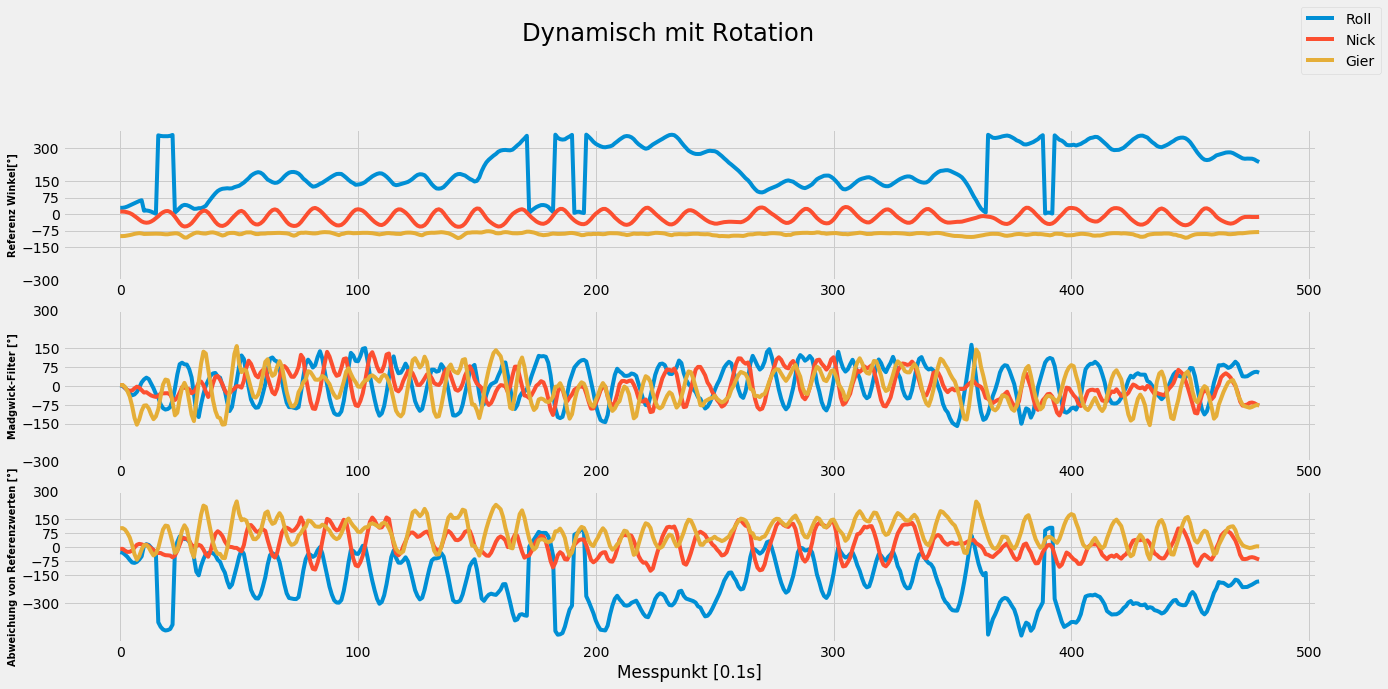

In [56]:
plt.style.use('fivethirtyeight')

# generate axes
x = list(range(len(q_analytic)))
xticks = np.array(list(range(0, 40))) * 40
yticks = np.array(list(range(-9, 10))) * 10

fig = plt.figure(figsize=(20,15))
p1 = fig.add_subplot(511)  # reference
p2 = fig.add_subplot(512)  # kalman
p3 = fig.add_subplot(513)  # delta

fig.suptitle('Dynamisch mit Rotation', fontsize='xx-large')

p1.plot(x, roll_reference)
p1.plot(x, pitch_reference)
p1.plot(x, yaw_reference)
p1.set_ylabel('Referenz Winkel[°]', fontsize='x-small', fontweight='bold')

p2.plot(x, roll_mad)
p2.plot(x, pitch_mad)
p2.plot(x, yaw_mad)
p2.set_ylabel('Madgwick-Filter [°]', fontsize='x-small', fontweight='bold')

p3.plot(x, delta_roll_mad)
p3.plot(x, delta_pitch_mad)
p3.plot(x, delta_yaw_mad)
p3.set_ylabel('Abweichung von Referenzwerten [°]', fontsize='x-small', fontweight='bold')
p3.set_xlabel('Messpunkt [0.1s]')

p1.set_yticks([-300, -150, -75, 0, 75, 150, 300])
p2.set_yticks([-300, -150, -75, 0, 75, 150, 300])
p3.set_yticks([-300, -150, -75, 0, 75, 150, 300])

l1, l2, l3 = p1.lines

fig.legend((l1, l2, l3), ('Roll', 'Nick', 'Gier'), 'upper right')

fig.savefig(os.path.join(os.getcwd(), 'dyn_rot_graph_3.png'))

[[236.66817402  71.55517501 108.42941409]
 [234.48734484  59.62020086  56.17811188]
 [239.95754225  71.11982509 109.94863135]
 [240.79329251  68.07695623 103.23059892]]


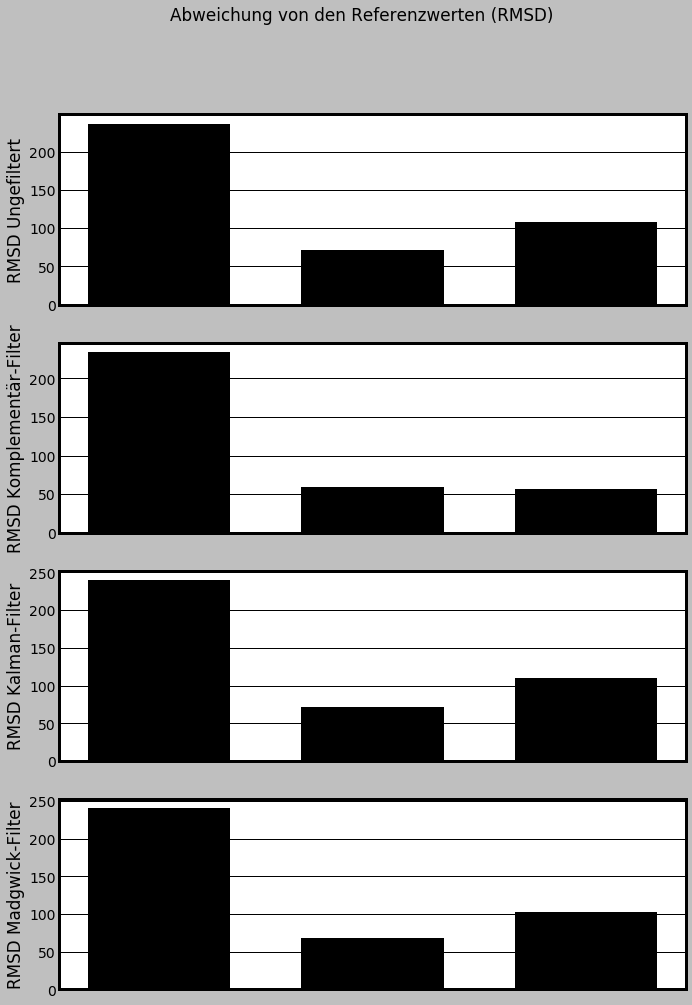

In [48]:
from sklearn.metrics import mean_squared_error

data = np.zeros((4,3))

data[0][0] = math.sqrt(mean_squared_error(roll_reference, roll_analytical))
data[0][1] = math.sqrt(mean_squared_error(pitch_reference, pitch_analytical))
data[0][2] = math.sqrt(mean_squared_error(yaw_reference, yaw_analytical))

data[1][0] = math.sqrt(mean_squared_error(roll_reference, roll_com))
data[1][1] = math.sqrt(mean_squared_error(pitch_reference, pitch_com))
data[1][2] = math.sqrt(mean_squared_error(yaw_reference, yaw_com))

data[2][0] = math.sqrt(mean_squared_error(roll_reference, roll_kal))
data[2][1] = math.sqrt(mean_squared_error(pitch_reference, pitch_kal))
data[2][2] = math.sqrt(mean_squared_error(yaw_reference, yaw_kal))

data[3][0] = math.sqrt(mean_squared_error(roll_reference, roll_mad))
data[3][1] = math.sqrt(mean_squared_error(pitch_reference, pitch_mad))
data[3][2] = math.sqrt(mean_squared_error(yaw_reference, yaw_mad))

print(data)

# plot rmsd error
columns = ('Ungefiltert', 'Komplementär-Filter', 'Kalman-Filter', 'Madgwick-Filter')
rows = ['Roll', 'Nick', 'Gier']

plt.style.use('grayscale')


fig = plt.figure(figsize=(10,15))

fig.suptitle('Abweichung von den Referenzwerten (RMSD)')

p1 = fig.add_subplot(411)
p2 = fig.add_subplot(412)
p3 = fig.add_subplot(413)
p4 = fig.add_subplot(414)

p1.bar([0.3, 0.6, 0.9], data[0], 0.2)
p1.set_ylabel('RMSD Ungefiltert')
p1.set_xticks([])

p2.bar([0.3, 0.6, 0.9], data[1], 0.2)
p2.set_ylabel('RMSD Komplementär-Filter')
p2.set_xticks([])

p3.bar([0.3, 0.6, 0.9], data[2], 0.2)
p3.set_ylabel('RMSD Kalman-Filter')
p3.set_xticks([])

p4.bar([0.3, 0.6, 0.9], data[3], 0.2)
p4.set_ylabel('RMSD Madgwick-Filter')
p4.set_xticks([])
fig.savefig(os.path.join(os.getcwd(), 'dyn_rot_deviation.png'))

In [49]:
means

[-204.889495711605,
 12.18534886995014,
 83.52569297465166,
 -207.27962796400237,
 40.549776125034214,
 52.66553961506745,
 -205.65276250364934,
 16.100590915878893,
 89.59878389210427,
 -196.278642664074,
 14.144117916539326,
 78.86999303654979]